In [2]:
# Load required libraries
import pandas as pd
import io
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [3]:
from google.colab import files
uploaded = files.upload()

Saving after_eda_before_modeling.csv to after_eda_before_modeling.csv


In [4]:
# Extract name of the uploaded file
filename = list(uploaded.keys())[0]
filename

'after_eda_before_modeling.csv'

In [5]:
# Read the uploaded file with pandas
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df.head()

,area,year,item,export_quantity,export_value,import_quantity,import_value,area_harvested,production,yield,gross_production_index,producer_price_index,area_agri_land,area_arable_land,area_cropland,area_with_irrigation,area_permanent_crops,area_temporary_crops,value_per_unit_agri_land,cropland_area_per_capita,gross_domestic_product,gross_fixed_capital_formation,value_added_ag_forest_fish,gdp_annual_growth,gfcf_annual_growth,value_added_ag_forest_fish_annual_growth,gfcf_share_in_total_gdp,ag_forest_fish_share_in_total_gdp,agri_orientation_index_govt_expenditure,govt_expenditure_on_ag_forest_fish,total_govt_expenditure,credit_to_ag_forest_fish,credit_to_ag_forest_fish_share_total_credit,aoi_credit_to_ag_forest_fish,total_credit,emission_share_farmgate,emission_share_land_use_change,emission_share_pre_and_post_production,emission_share_end_to_end_agrifood,emission_share_crops,...,potassium_use_per_capita,potassium_use_per_value_of_ag_production,cropland_nitrogen_use_efficiency,cropland_phosphorus_use_efficiency,cropland_potassium_use_efficiency,total_pesticide_use_for_agriculture,total_pesticide_use_per_area_of_cropland,total_pesticide_use_per_capita,total_pesticide_use_per_value_of_agri_production,total_pesticide_export_quantity,total_pesticide_export_value,total_pesticide_import_quantity,total_pesticide_import_value,region,sub_region,european_union_country,least_developed_country,land_locked_developing_country,small_island_developing_state,low_income_food_deficit_country,net_food_importing_developing_country,temp_change_meteorological_year,temp_change_dec_jan_feb,temp_change_jun_jul_aug,temp_change_sep_oct_nov,temp_change_mar_apr_may,total_foreign_investments,total_foreign_disinvestments,is_negative_fdi,nitrogen_replenish_per_unit_area,phosphorus_replenish_per_unit_area,potassium_replenish_per_unit_area,nitrogen_depletion_per_unit_area,phosphorus_depletion_per_unit_area,potassium_depletion_per_unit_area,is_negative_N_balance,is_negative_P_balance,is_negative_K_balance,zero_nitrogen_production,zero_phosphorus_production
0,Afghanistan,2001,"Almonds, in shell",10900.0,3000.0,10.877912,10.261501,9000.0,15000.00,1666.7,53.26,38.92,37795.0,7683.0,7795.0,3203.0,112.0,2502.0,99.47,0.3959,5031.596019,1722.202231,2872.475057,-5.675679,5.046214,-11.887739,34.227752,57.088746,0.107955,104.177940,1264.810309,0.547731,0.324356,0.0,345.368276,66.91,0.0,9.83,76.74,2.43,...,0.0,0.00,54.0557,100.2478,37.4952,39.044240,0.007771,0.000018,0.005142,0.095486,205.81970,104.438373,250.721779,Asia,South Asia,0.0,1.0,1.0,0.0,1.0,1.0,1.377,0.433,1.090,1.209,2.778,0.945025,0.0,0,5.9070,0.0,4.2790,0.000,0.0033,0.0,0,1,0,0,1
1,Afghanistan,2002,"Almonds, in shell",7355.0,2041.0,12.133391,13.651945,5500.0,11773.99,2140.7,41.81,35.17,37790.0,7678.0,7790.0,3208.0,112.0,2111.0,119.52,0.3709,8302.001638,2360.508428,3842.257463,64.997380,37.063370,33.761212,28.433004,46.281097,0.162877,137.167862,1380.046605,0.589992,0.215103,0.4,420.363316,69.59,0.0,9.90,79.49,2.77,...,0.0,0.00,78.7011,142.1943,46.3267,43.352999,0.003966,0.000026,0.003247,0.146559,34.37052,71.926123,333.903252,Asia,South Asia,0.0,1.0,1.0,0.0,1.0,1.0,1.457,1.722,0.991,1.589,1.524,96.868505,0.0,0,2.9409,0.0,4.0506,0.000,0.6225,0.0,0,1,0,0,1
2,Afghanistan,2003,"Almonds, in shell",7395.0,3219.0,9.425356,12.950618,5700.0,14000.00,2456.1,49.71,41.73,37884.0,7772.0,7884.0,3208.0,112.0,3761.0,121.87,0.3482,8918.205513,2451.021274,3976.299728,7.422353,3.834464,3.488633,27.483346,44.586321,0.130000,95.332249,1140.470000,0.583159,0.329533,0.0,377.376478,68.65,0.0,10.73,79.38,3.05,...,0.0,0.00,90.8200,143.1949,50.6300,38.141438,0.002831,0.000008,0.002885,0.123462,59.18278,81.203581,461.673693,Asia,South Asia,0.0,1.0,1.0,0.0,1.0,1.0,0.710,1.105,0.947,0.787,0.002,105.224384,0.0,0,1.2551,0.0,3.7393,0.000,0.7183,0.0,0,1,0,0,1
3,Afghanistan,2004,"Almonds, in shell",6163.0,3342.0,10.303944,14.898475,12000.0,14700.00,1225.0,52.20,42.67,37928.0,7816.0,7928.0,3208.0,112.0,2934.0,118.61,0.3366,9059.112101,2840.110148,340

In [6]:
# Split the dataset into train, validation, and test
train_df = df.loc[df['year'] <= 2021]
val_df = df.loc[df['year'] == 2022]
test_df = df.loc[df['year'] == 2023]

len(train_df), len(val_df), len(test_df)

(106771, 5218, 5218)

In [7]:
# Categorical features
categorical_cols = ['area', 'item', 'region', 'sub_region']

# Target column
target_col = 'producer_price_index'

# Binary columns
binary_cols = [col for col in df.columns if df[col].isin([0,1]).all()]

# Numerical columns
numerical_cols = [
    col for col in df.columns
    if col not in categorical_cols + binary_cols + [target_col, 'year']
    ]

categorical_cols, binary_cols, numerical_cols[:10], len(numerical_cols)

(['area', 'item', 'region', 'sub_region'],
 ['european_union_country',
  'least_developed_country',
  'land_locked_developing_country',
  'small_island_developing_state',
  'low_income_food_deficit_country',
  'net_food_importing_developing_country',
  'is_negative_fdi',
  'is_negative_N_balance',
  'is_negative_P_balance',
  'is_negative_K_balance',
  'zero_nitrogen_production',
  'zero_phosphorus_production'],
 ['export_quantity',
  'export_value',
  'import_quantity',
  'import_value',
  'area_harvested',
  'production',
  'yield',
  'gross_production_index',
  'area_agri_land',
  'area_arable_land'],
 92)

In [12]:
# Remove 'year' from PowerTransformer
numerical_cols_no_year = [c for c in numerical_cols if c != 'year']

# Yeo-Johnson transformation for numerical features
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(train_df[numerical_cols_no_year])

train_num = pt.transform(train_df[numerical_cols_no_year])
val_num = pt.transform(val_df[numerical_cols_no_year])
test_num = pt.transform(test_df[numerical_cols_no_year])

# Standard Scaler after Yeo-Johnson
ss = StandardScaler()
ss.fit(train_num)

train_num_scaled = ss.transform(train_num)
val_num_scaled = ss.transform(val_num)
test_num_scaled = ss.transform(test_num)

# 3) Now scale year only with StandardScaler — no Yeo-Johnson!
ss_year = StandardScaler()
ss_year.fit(train_df[['year']])

train_year_scaled = ss_year.transform(train_df[['year']])
val_year_scaled   = ss_year.transform(val_df[['year']])
test_year_scaled  = ss_year.transform(test_df[['year']])

# Transform target using log1p
y_train_raw = train_df[target_col].values
y_val_raw   = val_df[target_col].values
y_test_raw  = test_df[target_col].values

y_train = np.log1p(train_df[target_col].values)
y_val = np.log1p(val_df[target_col].values)
y_test = np.log1p(test_df[target_col].values)

In [13]:
# Concatenate scaled numeric features with binary features
train_num_final = np.hstack([train_num_scaled, train_df[binary_cols].values, train_year_scaled])
val_num_final = np.hstack([val_num_scaled, val_df[binary_cols].values, val_year_scaled])
test_num_final = np.hstack([test_num_scaled, test_df[binary_cols].values, test_year_scaled])

In [ ]:
# Integer encoding the categorical features (to prepare for embedding)
label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  le.fit(train_df[col])
  train_df[col] = le.transform(train_df[col])
  val_df[col] = le.transform(val_df[col])
  test_df[col] = le.transform(test_df[col])

  # save le for each categorical col (to be used later for inverse transforming
  # if needed)
  label_encoders[col] = le

In [115]:
# verify no unseen categories appear in validation/test sets
# this is important, otherwise PyTorch will crash
for col in categorical_cols:
  print(
      col,
      train_df[col].max(),
      val_df[col].max(),
      test_df[col].max()
  )

area 146 146 146
item 99 99 99
region 4 4 4
sub_region 20 20 20


In [116]:
# Categorical features after label encoding
train_cat = train_df[categorical_cols].values
val_cat = val_df[categorical_cols].values
test_cat = test_df[categorical_cols].values

train_cat.shape, val_cat.shape, test_cat.shape

((106771, 4), (5218, 4), (5218, 4))

## Build PyTorch Dataset class

In [117]:
class PPIDataset(Dataset):
  def __init__(self, num_data, cat_data, targets=None):
    """
    num_data: numpy array of numeric features
    cat_data: numpy array of categorical features
    targets: numpy array of target
    """
    self.num_data = torch.tensor(num_data, dtype=torch.float32)
    self.cat_data = torch.tensor(cat_data, dtype=torch.long)

    if targets is not None:
      self.targets = torch.tensor(targets, dtype=torch.float32)
    else:
      self.targets = None

  def __len__(self):
    return len(self.num_data)

  def __getitem__(self, idx):
    if self.targets is not None:
      return self.num_data[idx], self.cat_data[idx], self.targets[idx]
    else:
      return self.num_data[idx], self.cat_data[idx]


In [118]:
# Create Dataset objects
train_dataset = PPIDataset(train_num_final, train_cat, y_train)
val_dataset = PPIDataset(val_num_final, val_cat, y_val)
test_dataset = PPIDataset(test_num_final, test_cat)

len(train_dataset), len(val_dataset), len(test_dataset)

(106771, 5218, 5218)

## Build DataLoaders

In [119]:
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [120]:
# Check one batch
num_batch, cat_batch, target_batch = next(iter(train_loader))
num_batch.shape, cat_batch.shape, target_batch.shape

(torch.Size([1024, 105]), torch.Size([1024, 4]), torch.Size([1024]))

## Define Embedding sizes

In [121]:
# Number of unique categories for each categorical column
cat_cardinalities = {
    col: len(label_encoders[col].classes_)
    for col in categorical_cols
}

# Corresponding embedding dimensions
embedding_dims = {
    'area': 16,
    'item': 16,
    'region': 2,
    'sub_region': 4
}

## Build Neural Network module

In [122]:
class PPINet(nn.Module):
  def __init__(self, cat_cardinalities, embedding_dims, num_numeric_features):
    super().__init__()

    # Embedding layers
    self.embeddings = nn.ModuleDict({
        col: nn.Embedding(cat_cardinalities[col], embedding_dims[col])
        for col in cat_cardinalities
    })

    # Total embedding size after concatenation
    total_emb_dim = sum(embedding_dims.values())

    # Fully connected numerical + embedding network
    input_dim = num_numeric_features + total_emb_dim

    self.fc = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 1)
    )

  def forward(self, num_x, cat_x):
    # pass each categorical column through its embedding
    emb_list = []
    for i, col in enumerate(self.embeddings.keys()):
      emb = self.embeddings[col](cat_x[:, i])
      emb_list.append(emb)

    # Concatenate embeddings
    emb_cat = torch.cat(emb_list, dim=1)

    # Concatenate numerical features + embeddings
    x = torch.cat([num_x, emb_cat], dim=1)

    # Forward pass through MLP
    out = self.fc(x)

    return F.softplus(out).squeeze()

## Instantiate the model

In [123]:
num_numeric_features = train_num_final.shape[1]

model = PPINet(cat_cardinalities, embedding_dims, num_numeric_features)
model

PPINet(
  (embeddings): ModuleDict(
    (area): Embedding(147, 16)
    (item): Embedding(100, 16)
    (region): Embedding(5, 2)
    (sub_region): Embedding(21, 4)
  )
  (fc): Sequential(
    (0): Linear(in_features=143, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Define optimizer and loss

In [124]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

## Set up GPU device and move the model to CUDA

In [125]:
# Detect GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [126]:
model = model.to(device)

## Build the full Training loop with early stopping

In [127]:
best_loss = np.inf
patience = 5
patience_ct = 0

for epoch in range(1, 60):
    model.train()
    train_loss = 0

    for num_x, cat_x, y in train_loader:
        num_x, cat_x, y = num_x.cuda(), cat_x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(num_x, cat_x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * num_x.size(0)

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for num_x, cat_x, y in val_loader:
            num_x, cat_x, y = num_x.cuda(), cat_x.cuda(), y.cuda()
            out = model(num_x, cat_x)
            val_loss += criterion(out, y).item() * num_x.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_ct = 0
        torch.save(model.state_dict(), "best_ppi.pth")
    else:
        patience_ct += 1

    if patience_ct >= patience:
        print("Early stopping.")
        break


Epoch 01 | Train 1.6909 | Val 0.3238
Epoch 02 | Train 0.2433 | Val 0.2708
Epoch 03 | Train 0.2237 | Val 0.2439
Epoch 04 | Train 0.2104 | Val 0.2338
Epoch 05 | Train 0.2015 | Val 0.2698
Epoch 06 | Train 0.1928 | Val 0.2208
Epoch 07 | Train 0.1861 | Val 0.2247
Epoch 08 | Train 0.1825 | Val 0.2291
Epoch 09 | Train 0.1761 | Val 0.2133
Epoch 10 | Train 0.1715 | Val 0.2114
Epoch 11 | Train 0.1654 | Val 0.2109
Epoch 12 | Train 0.1609 | Val 0.1963
Epoch 13 | Train 0.1583 | Val 0.2146
Epoch 14 | Train 0.1515 | Val 0.2224
Epoch 15 | Train 0.1445 | Val 0.2302
Epoch 16 | Train 0.1398 | Val 0.2218
Epoch 17 | Train 0.1349 | Val 0.1926
Epoch 18 | Train 0.1286 | Val 0.1639
Epoch 19 | Train 0.1258 | Val 0.1782
Epoch 20 | Train 0.1220 | Val 0.1956
Epoch 21 | Train 0.1169 | Val 0.1790
Epoch 22 | Train 0.1147 | Val 0.1674
Epoch 23 | Train 0.1119 | Val 0.2020
Early stopping.


## Evaluate on 2023

In [128]:
model.load_state_dict(torch.load("best_ppi.pth"))
model.eval()

pred_log = []
with torch.no_grad():
    for num_x, cat_x in test_loader:
        num_x, cat_x = num_x.cuda(), cat_x.cuda()
        out = model(num_x, cat_x)
        pred_log.append(out.cpu().numpy())

pred_log = np.concatenate(pred_log)
pred_ppi = np.expm1(pred_log)  # inverse log transform


## Evaluation Results

In [129]:
rmse = root_mean_squared_error(y_test_raw, pred_ppi)
mae  = mean_absolute_error(y_test_raw, pred_ppi)
r2   = r2_score(y_test_raw, pred_ppi)

rmse, mae, r2

(177.4915618227414, 67.51540877512197, 0.15759649350386307)

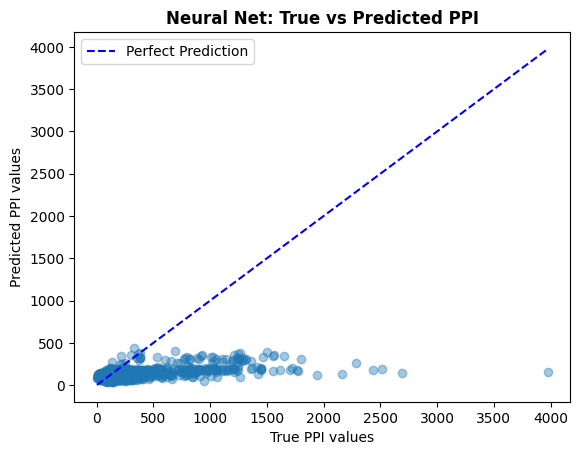

In [107]:
# Plot the true versus predicted values
plt.scatter(y_test_raw, pred_ppi, alpha=0.4)
plt.xlabel("True PPI values")
plt.ylabel("Predicted PPI values")
plt.title("Neural Net: True vs Predicted PPI", fontweight='bold')

minv, maxv = y_test_raw.min(), y_test_raw.max()
plt.plot([minv, maxv], [minv, maxv], "b--", linewidth=1.5, label='Perfect Prediction')
plt.legend()
plt.savefig(f'NeuralNet_true_vs_predicted.png', dpi=360, bbox_inches='tight')
plt.show()

In [108]:
from google.colab import files
files.download('NeuralNet_true_vs_predicted.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>